# 🧬 Training pipeline: Training retrieval model

In this notebook, you will train a retrieval model that will be able to quickly generate a small subset of candidate items from a large collection of items. Your model will be based on the *two-tower architecture*, which embeds queries and candidates (keys) into a shared low-dimensional vector space. Here, a query consists of features of a customer and a transaction (e.g. timestamp of the purchase), whereas a candidate consists of features of a particular item. All queries will have a user ID and all candidates will have an item ID, and the model will be trained such that the embedding of a user will be close to all the embeddings of items the user has previously bought.

After training the model you will save and upload its components to the Vertex AI Model Registry.

Let's go ahead and load the data.

## 📝 Imports

In [43]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

from loguru import logger

from recsys.config import settings
from recsys import gcp_integrations, training
from recsys.gcp_integrations.two_tower_serving import GCPQueryModel, GCPCandidateModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ☁️ Connect to Vertex AI Feature Online Store

In [21]:
fos = gcp_integrations.get_feature_store()

2025-02-14 11:15:32.273 | INFO     | recsys.gcp_integrations.feature_store:get_feature_store:23 - Retrieving Feature Store from us-central1/recsys-dev-gonzo/recsys_feature_store_dev


## 💿 Create training dataset
You will train your retrieval model with a subset of features.

For the query embedding you will use:
- `customer_id`: ID of the customer.
- `age`: age of the customer at the time of purchase.
- `month_sin`, `month_cos`: time of year the purchase was made.

For the candidate embedding you will use:
- `article_id`: ID of the item.
- `garment_group_name`: type of garment.
- `index_group_name`: menswear/ladieswear etc.

In [22]:
trans_fv, articles_fv, customers_fv = gcp_integrations.feature_store.create_retrieval_feature_view(fos)

In [23]:
training_data = gcp_integrations.feature_store.create_training_dataset(trans_fv, articles_fv, customers_fv)

2025-02-14 11:15:36.445 | INFO     | recsys.features.ranking:fetch_feature_view_data:19 - Starting to fetch data from feature view: transactions
2025-02-14 11:15:38.066 | INFO     | recsys.features.ranking:fetch_feature_view_data:33 - Executing query: SELECT customer_id, article_id, t_dat, price, month_sin, month_cos FROM `recsys-dev-gonzo.recsys_dataset.recsys_transactions`
2025-02-14 11:15:43.521 | INFO     | recsys.features.ranking:fetch_feature_view_data:37 - DataFrame shape: (23799, 6)
2025-02-14 11:15:43.522 | INFO     | recsys.features.ranking:fetch_feature_view_data:19 - Starting to fetch data from feature view: customers
2025-02-14 11:15:44.022 | INFO     | recsys.features.ranking:fetch_feature_view_data:33 - Executing query: SELECT customer_id, age, club_member_status, age_group FROM `recsys-dev-gonzo.recsys_dataset.recsys_customers`
2025-02-14 11:15:46.242 | INFO     | recsys.features.ranking:fetch_feature_view_data:37 - DataFrame shape: (1000, 4)
2025-02-14 11:15:46.243 | I

In [24]:
dataset = training.two_tower.TwoTowerDataset(
    training_data=training_data , batch_size=settings.TWO_TOWER_MODEL_BATCH_SIZE
)



In [25]:
train_ds, val_ds = dataset.get_train_val_split()

2025-02-14 11:15:52.819 | INFO     | recsys.training.two_tower:get_train_val_split:258 - Retrieving and creating train, eval, test split...


Let's take a look at our dataset:

In [26]:
logger.info(f"Training samples: {len(dataset.properties['train_df']):,}")
logger.info(f"Validation samples: {len(dataset.properties['val_df']):,}")

logger.info(f"Number of users: {len(dataset.properties['user_ids']):,}")
logger.info(f"Number of items: {len(dataset.properties['item_ids']):,}")

2025-02-14 11:15:52.915 | INFO     | __main__:<module>:1 - Training samples: 19,005
2025-02-14 11:15:52.915 | INFO     | __main__:<module>:2 - Validation samples: 2,389
2025-02-14 11:15:52.915 | INFO     | __main__:<module>:4 - Number of users: 967
2025-02-14 11:15:52.915 | INFO     | __main__:<module>:5 - Number of items: 12,031


In [27]:
dataset.properties["train_df"].head()

customer_id,article_id,t_dat,price,month_sin,month_cos,age,club_member_status,age_group,garment_group_name,index_group_name
str,str,i64,f64,f64,f64,f64,str,str,str,str
"""20409548ee6c82016a0c499389cee3…","""618800007""",1566777600,0.033881,-0.866025,-0.5,26.0,"""PRE-CREATE""","""26-35""","""Blouses""","""Ladieswear"""
"""f078fde7e59a1450c95aeca532f8db…","""893351002""",1592352000,0.015237,1.2246e-16,-1.0,45.0,"""ACTIVE""","""36-45""","""Dresses Ladies""","""Divided"""
"""e4ff7e2563aa65a05ef1b753ccf0a1…","""464277017""",1577836800,0.022017,0.5,0.866025,51.0,"""ACTIVE""","""46-55""","""Under-, Nightwear""","""Ladieswear"""
"""7230bd0e13cdb38ce9d09bc7126d71…","""801512004""",1562630400,0.042356,-0.5,-0.866025,28.0,"""PRE-CREATE""","""26-35""","""Jersey Fancy""","""Sport"""
"""67b2fb6ebf802abcc7310bf98847fb…","""850917001""",1600560000,0.025407,-1.0,-1.8370e-16,19.0,"""ACTIVE""","""19-25""","""Blouses""","""Ladieswear"""


## 🗼🗼 Build the Two Tower model

The two tower model consist of two models:
- **Query model**: Generates a query representation of a given user and transaction features.
- **Candidate model**: Generates an item representation given item features.

**Both models produce embeddings that live in the same embedding space**. You let this space be low-dimensional to prevent overfitting on the training data. (Otherwise, the model might simply memorize previous purchases, which makes it recommend items customers already have bought).

You start with creating the query model.

In [28]:
query_model_factory = training.two_tower.QueryTowerFactory(dataset=dataset)
query_model = query_model_factory.build()

The candidate model is very similar to the query model. A difference is that it has two categorical features as input, which you one-hot encode.

In [29]:
item_model_factory = training.two_tower.ItemTowerFactory(dataset=dataset)
item_model = item_model_factory.build()

You will evaluate the two tower model using the *top-100 accuracy*. That is, for each transaction in the validation data you will generate the associated query embedding and retrieve the set of the 100 items that are closest to this query in the embedding space. The top-100 accuracy measures how often the item that was actually bought is part of this subset. To evaluate this, you create a dataset of all unique items in the training data.

Create a TwoTowerModel with the specified **query_model** and **item_model**:

In [30]:
model_factory = training.two_tower.TwoTowerFactory(dataset=dataset)
model = model_factory.build(query_model=query_model, item_model=item_model)

### Training the model

In [31]:
trainer = training.two_tower.TwoTowerTrainer(dataset=dataset, model=model)
history = trainer.train(train_ds, val_ds)

Epoch 1/10
10/10 [==============================] - 1s 21ms/step - loss: 14476.2648 - regularization_loss: 0.0000e+00 - total_loss: 14476.2648 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 1964.1647 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1964.1647
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 14011.9747 - regularization_loss: 0.0000e+00 - total_loss: 14011.9747 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+0

Let's take a look at the training and validation loss:

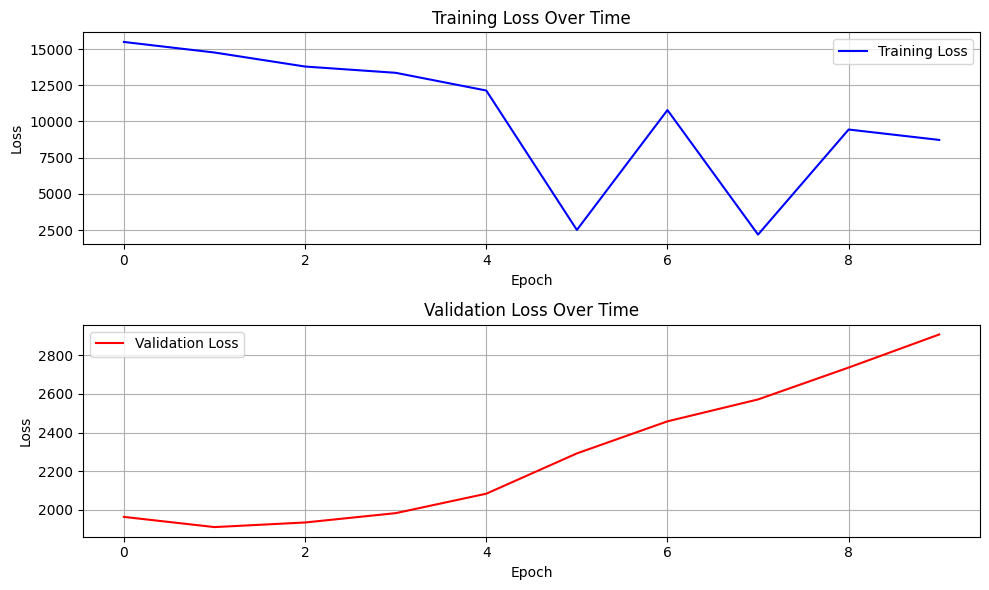

In [32]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Training loss subplot
ax1.plot(history.history["loss"], label="Training Loss", color="blue")
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Validation loss subplot
ax2.plot(history.history["val_loss"], label="Validation Loss", color="red")
ax2.set_title("Validation Loss Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()  # Uncomment to show the plot

# 🗄️ Upload models to Vertex AI model registry

In [36]:
query_model_gcp = GCPQueryModel(model=query_model)
item_model_gcp = GCPCandidateModel(model=item_model)

In [37]:
query_local_path = query_model_gcp.save_to_local("query_model")
item_model_path = item_model_gcp.save_to_local("item_model")

INFO:tensorflow:Assets written to: query_model/assets


INFO:tensorflow:Assets written to: query_model/assets


INFO:tensorflow:Assets written to: item_model/assets


INFO:tensorflow:Assets written to: item_model/assets


In [40]:
query_model_vertex = query_model_gcp.upload_to_vertex_ai(
    model_name="query_tower_v1",
    description="Query tower model for two-tower recommender system",
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
)

item_model_vertex = item_model_gcp.upload_to_vertex_ai(
    model_name="candidate_tower_v1",
    description="Item tower model for two-tower recommender system",
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
)

2025-02-14 11:52:32.297 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:22 - Saving model into: /tmp/query_model


INFO:tensorflow:Assets written to: /tmp/query_model/assets


INFO:tensorflow:Assets written to: /tmp/query_model/assets
2025-02-14 11:52:32.508 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:25 - Uploading model to query_tower_v1 to Vertex AI


Creating Model
Create Model backing LRO: projects/99924275580/locations/us-central1/models/5579622388242317312/operations/4133402755312123904
Model created. Resource name: projects/99924275580/locations/us-central1/models/5579622388242317312@1
To use this Model in another session:
model = aiplatform.Model('projects/99924275580/locations/us-central1/models/5579622388242317312@1')


2025-02-14 11:55:44.805 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:35 - Model uploadded with resource name: projects/99924275580/locations/us-central1/models/5579622388242317312
2025-02-14 11:55:44.813 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:22 - Saving model into: /tmp/item_model


INFO:tensorflow:Assets written to: /tmp/item_model/assets


INFO:tensorflow:Assets written to: /tmp/item_model/assets
2025-02-14 11:55:45.442 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:25 - Uploading model to candidate_tower_v1 to Vertex AI


Creating Model
Create Model backing LRO: projects/99924275580/locations/us-central1/models/483799409872601088/operations/924025070857224192
Model created. Resource name: projects/99924275580/locations/us-central1/models/483799409872601088@1
To use this Model in another session:
model = aiplatform.Model('projects/99924275580/locations/us-central1/models/483799409872601088@1')


2025-02-14 11:55:58.960 | INFO     | recsys.gcp_integrations.model_registry:upload_model_to_registry:35 - Model uploadded with resource name: projects/99924275580/locations/us-central1/models/483799409872601088


In [46]:
query_endpoint = query_model_gcp.deploy_endpoint(
    model=query_model_vertex,
    endpoint_id="recsys-query-model"
)


item_endpoint = item_model_gcp.deploy_endpoint(
    model=item_model_vertex,
    endpoint_id="recsys-candidate-model"
)

2025-02-14 12:27:31.467 | INFO     | recsys.gcp_integrations.two_tower_serving:deploy_endpoint:70 - Found existing endpoint: recsys-query-model


Deploying model to Endpoint : projects/99924275580/locations/us-central1/endpoints/recsys-query-model
Deploy Endpoint model backing LRO: projects/99924275580/locations/us-central1/endpoints/recsys-query-model/operations/6247279830409150464
Endpoint model deployed. Resource name: projects/99924275580/locations/us-central1/endpoints/recsys-query-model


2025-02-14 12:38:49.059 | INFO     | recsys.gcp_integrations.two_tower_serving:deploy_endpoint:83 - Model deployed to endpoint: projects/99924275580/locations/us-central1/endpoints/recsys-query-model
2025-02-14 12:38:49.894 | INFO     | recsys.gcp_integrations.two_tower_serving:deploy_endpoint:70 - Found existing endpoint: recsys-candidate-model


Deploying model to Endpoint : projects/99924275580/locations/us-central1/endpoints/recsys-candidate-model
Deploy Endpoint model backing LRO: projects/99924275580/locations/us-central1/endpoints/recsys-candidate-model/operations/6195488434694389760
Endpoint model deployed. Resource name: projects/99924275580/locations/us-central1/endpoints/recsys-candidate-model


2025-02-14 12:41:50.617 | INFO     | recsys.gcp_integrations.two_tower_serving:deploy_endpoint:83 - Model deployed to endpoint: projects/99924275580/locations/us-central1/endpoints/recsys-candidate-model
